In [146]:
%matplotlib inline
import matplotlib as lib
import pandas as pd
from bs4 import BeautifulSoup
import requests
import json
from altair import Chart, X, Y, Axis, SortField

# Data gathering and calculating in class without graphs

In [147]:
sfa=pd.read_csv('Data/sfa1314.csv')
name=pd.read_csv('Data/hd2014.csv',encoding='ISO-8859-1')
gr14=pd.read_csv('Data/gr2014.csv')

In [148]:
pf=pd.merge(sfa,name,left_on='UNITID',right_on='UNITID')
midwest=['IA','IL','MN','WI','MO','KS','MI','SD','OH','ND','NE']
def region(row):
    if row['STABBR'] in midwest:
        return "Midwest"
pf['Region']=pf.apply(region,axis=1)
pell=pf[pf.Region=="Midwest"].sort_values('PGRNT_P',ascending=False)[['UNITID','INSTNM','PGRNT_P']]
#take the pell grant data

In [149]:
x=gr14.pivot_table(columns='GRTYPE',values='GRTOTLT',index='UNITID')[[2,3]]
pfGr=pd.merge(pf,x,left_on='UNITID',right_index=True)
pfGr.fillna(0,inplace=True)
def getPcGrd(row):
    if row[2]==0:
        return 0
    else:
        return float(row[3])/float(row[2])*100
pfGr['%Grad6']=pfGr.apply(getPcGrd,axis=1)
pfGr['PGrad6']=pfGr['PGRNT_P']/100*pfGr['%Grad6']
pf=pfGr
pfGr=pf[pf.Region=='Midwest'].sort_values('PGrad6',ascending=False)[['INSTNM','UNITID','PGrad6']]
#calculate student grad in 6 years and have pell grants

# Plot average net price for students from family with income 30k-48k and 48k-75k in Midwest

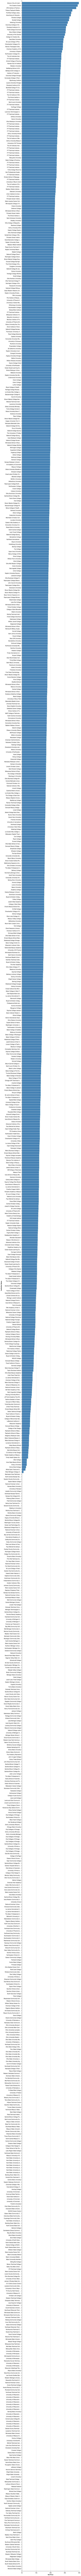

In [150]:
pf['Average']=(pf['NPT432']+pf['NPT422'])/2 #calculating  net price, which is the average of middle class income
npm=pf[pf.Region=='Midwest'].sort_values('Average',ascending=False)[['INSTNM','UNITID','Average','Region']]
Chart(npm).mark_bar().encode(
    y=Y('INSTNM',sort=SortField(field='amount', order='descending'),
        axis=Axis(title='Institution Name')),
     x=X('Average',
        axis=Axis(title='Net Price'))
)
#graph the net price

In [151]:
pfGr.head()['PGrad6']

1248    100.000000
1186     75.000000
4623     72.765957
2784     61.328571
5296     57.000000
Name: PGrad6, dtype: float64

In [152]:
apg=pfGr[pfGr.PGrad6!=0]['PGrad6'].mean() #calculate the mean of student graduate within 6 years with Pell grants 
anp=npm[npm.Average!=0]['Average'].mean() #calculate the mean of net price
sdpg=pfGr[pfGr.PGrad6!=0]['PGrad6'].std() #calculate standard deviation of student graduate within 6 years with Pell grants 
sdnp=npm[npm.Average!=0]['Average'].std() #calculate the standard deviation of net price 
apg,anp,sdpg,sdnp

(20.781097468425408, 16987.618464052288, 9.7256447415448406, 6032.683180699355)

### Calculate Index in a different way

In [159]:
def getPGradIndex(row):
    return (row['PGrad6']-apg)/sdpg
def getNPIndex(row):
    return (row['Average']-anp)/sdnp
pfGr['PGradIndex']=pfGr.apply(getPGradIndex,axis=1)
npm['NPIndex']=npm.apply(getNPIndex,axis=1)
#I have a little bit different in the way of calculating the index: I normalize each datapoint by using the statistic normalization formular

In [154]:
pfGr.head()

INSTNM  UNITID      PGrad6  \
1248                             St Luke's College  154262  100.000000   
1186                                 Allen College  152798   75.000000   
4623                         Wright Career College  406200   72.765957   
2784                               Hondros College  203386   61.328571   
5296  Pacific College of Oriental Medicine-Chicago  442842   57.000000   

      PGradIndex  
1248    8.145363  
1186    5.574839  
4623    5.345133  
2784    4.169130  
5296    3.724062

In [155]:
npm.head()

INSTNM  UNITID  Average   Region  \
942   School of the Art Institute of Chicago  143048  39770.0  Midwest   
4953                     The Creative Center  430485  38967.0  Midwest   
5137             ATS Institute of Technology  439455  37943.5  Midwest   
6373   Tribeca Flashpoint Media Arts Academy  460747  35174.5  Midwest   
2859           Pontifical College Josephinum  205027  34488.5  Midwest   

       NPIndex  
942   3.776492  
4953  3.643384  
5137  3.473725  
6373  3.014725  
2859  2.901011

In [156]:
final=pd.merge(npm,pfGr,right_on='UNITID',left_on='UNITID')
final.head()

INSTNM_x  UNITID  Average   Region   NPIndex  \
0  School of the Art Institute of Chicago  143048  39770.0  Midwest  3.776492   
1                     The Creative Center  430485  38967.0  Midwest  3.643384   
2             ATS Institute of Technology  439455  37943.5  Midwest  3.473725   
3   Tribeca Flashpoint Media Arts Academy  460747  35174.5  Midwest  3.014725   
4           Pontifical College Josephinum  205027  34488.5  Midwest  2.901011   

                                 INSTNM_y     PGrad6  PGradIndex  
0  School of the Art Institute of Chicago  10.285714   -1.079145  
1                     The Creative Center  24.510638    0.383475  
2             ATS Institute of Technology   0.000000   -2.136732  
3   Tribeca Flashpoint Media Arts Academy  16.495413   -0.440658  
4           Pontifical College Josephinum  17.272727   -0.360734

In [165]:
final['CollegeIndex']=final['NPIndex']+final['PGradIndex']
final[final.INSTNM_x=='Luther College']
collegeIndex=final[(final.Region=='Midwest') & (final.Average!=0) & (final.PGrad6!=0)].sort_values('CollegeIndex',ascending=True)
collegeIndex.head()

INSTNM_x  UNITID  Average   Region   NPIndex  \
588  Bryant & Stratton College-Cleveland  202684   5741.0  Midwest -1.864281   
581   Yeshiva Gedolah of Greater Detroit  247773   6456.5  Midwest -1.745677   
561            Rabbinical College Telshe  205124   8478.5  Midwest -1.410503   
589          College of Menominee Nation  413617   5699.5  Midwest -1.871160   
608                    Cleary University  169327   3346.0  Midwest -2.261285   

                                INSTNM_y     PGrad6  PGradIndex  CollegeIndex  
588  Bryant & Stratton College-Cleveland   7.485981   -1.367016     -3.231298  
581   Yeshiva Gedolah of Greater Detroit   8.421053   -1.270872     -3.016549  
561            Rabbinical College Telshe   5.166667   -1.605491     -3.015994  
589          College of Menominee Nation  11.571429   -0.946947     -2.818107  
608                    Cleary University  15.909091   -0.500944     -2.762230

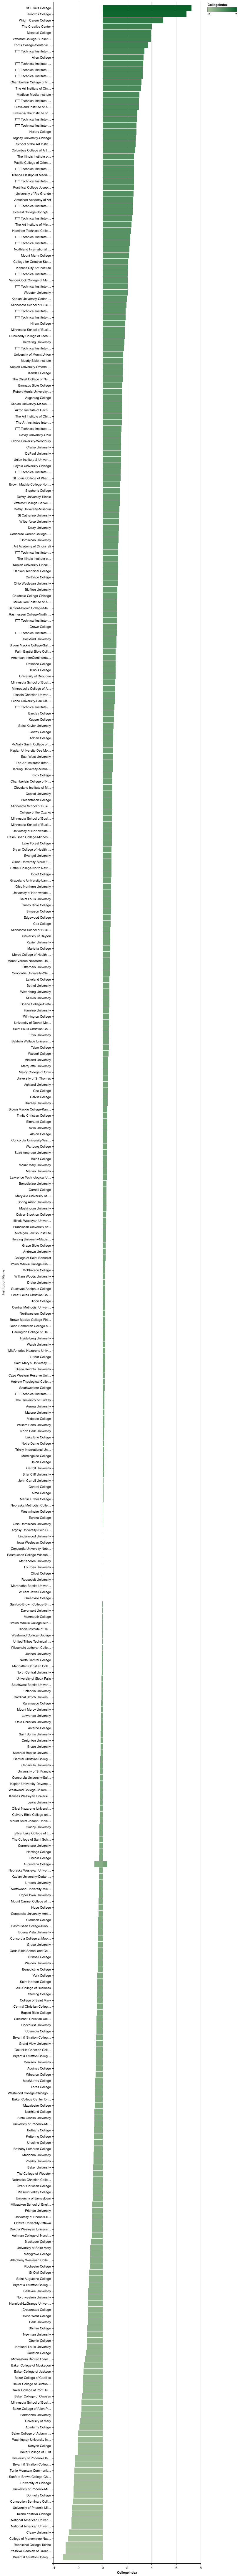

In [169]:
Chart(collegeIndex).mark_bar().encode(
    y=Y('INSTNM_x',sort=SortField(field='CollegeIndex', order='descending',op='sum'),
        axis=Axis(title='Institution Name')),
     x=X('CollegeIndex',
        axis=Axis(title='CollegeIndex')), color='CollegeIndex'
)

## A second way of calculating the index: this way create ranking in the range of (0,2)

In [174]:
def getPGradIndex2(row):
    return row['PGrad6']/apg
def getNPIndex2(row):
    return row['Average']/anp
pfGr['PGradIndex2']=pfGr.apply(getPGradIndex2,axis=1)
npm['NPIndex2']=npm.apply(getNPIndex2,axis=1)

In [175]:
final=pd.merge(npm,pfGr,right_on='UNITID',left_on='UNITID')
final['CollegeIndex2']=final['NPIndex2']*final['PGradIndex2']
collegeIndex=final[(final.Region=='Midwest') & (final.Average!=0) & (final.PGrad6!=0)].sort_values('CollegeIndex2',ascending=True)
collegeIndex.head()

INSTNM_x  UNITID  Average   Region   NPIndex  \
436          Conception Seminary College  177083  13776.5  Midwest -0.532287   
588  Bryant & Stratton College-Cleveland  202684   5741.0  Midwest -1.864281   
561            Rabbinical College Telshe  205124   8478.5  Midwest -1.410503   
608                    Cleary University  169327   3346.0  Midwest -2.261285   
581   Yeshiva Gedolah of Greater Detroit  247773   6456.5  Midwest -1.745677   

     NPIndex2                             INSTNM_y     PGrad6  PGradIndex  \
436  0.810973          Conception Seminary College   2.166667   -1.913953   
588  0.337952  Bryant & Stratton College-Cleveland   7.485981   -1.367016   
561  0.499099            Rabbinical College Telshe   5.166667   -1.605491   
608  0.196967                    Cleary University  15.909091   -0.500944   
581  0.380071   Yeshiva Gedolah of Greater Detroit   8.421053   -1.270872   

     PGradIndex2  CollegeIndex2  
436     0.104261       0.084553  
588     0.360230       0.121741  
561     0.248623       0.124088  
608     0.765556       0.150789  
581     0.405227       0.154015

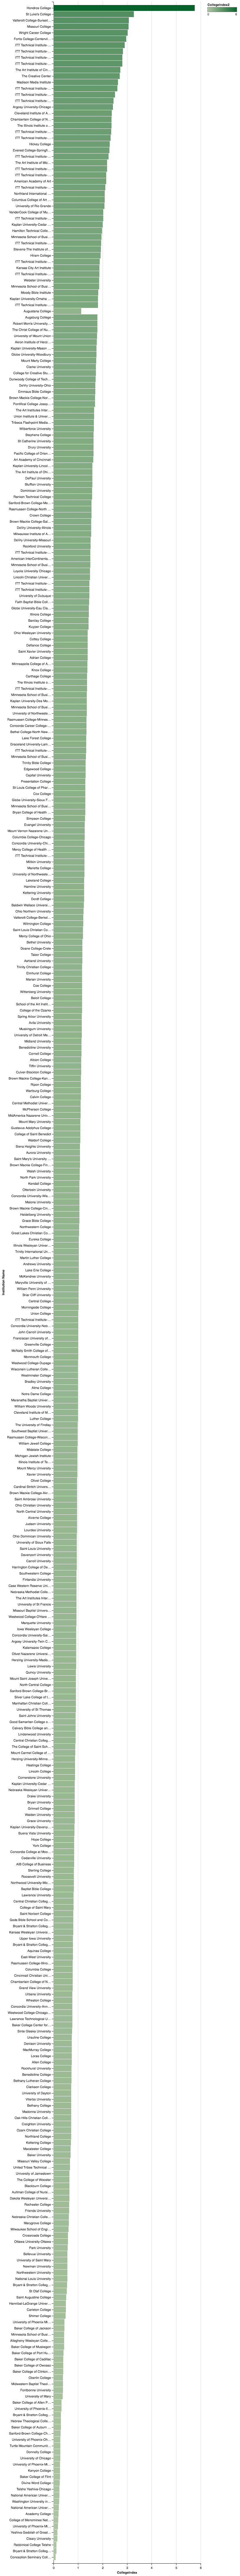

In [181]:
Chart(collegeIndex).mark_bar().encode(
    y=Y('INSTNM_x',sort=SortField(field='CollegeIndex2', order='descending',op='sum'),
        axis=Axis(title='Institution Name')),
     x=X('CollegeIndex2',
        axis=Axis(title='CollegeIndex')), color='CollegeIndex2'
)

In [183]:
final[final.INSTNM_x=='Hondros College']

INSTNM_x  UNITID  Average   Region  NPIndex  NPIndex2  \
6  Hondros College  203386  33168.0  Midwest  2.68212  1.952481   

          INSTNM_y     PGrad6  PGradIndex  PGradIndex2  CollegeIndex2  
6  Hondros College  61.328571     4.16913     2.951171       5.762105